In [1]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from scipy import signal
from scipy.interpolate import interp1d
from utils import minmax_normalize_param, unnormalize_params, real_files_to_tensors
import tensorflow as tf

from models import EncoderDecoderModel

2023-11-29 09:58:48.308870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 09:58:55.314121: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 09:58:57.206048: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-11-29 09:58:57

In [11]:

IMG_OUTPUT_SIZE = 128
latent_dim = 7  # 6 + the new VrfSPS

zeropad = 14
start_turn = 1
skipturns = 3
Ib = 1.6e11

cut_left = 0
cut_right = 2.5e-9
n_slices = 100
timescale = np.linspace(cut_left, cut_right, n_slices, endpoint=False)

normalization = 'minmax'
img_normalize = 'off'
ps_normalize = 'off'

# E_normFactor = 25000000000.0
# B_normFactor = 800000000.0
T_normFactor = 28000000000.0

var_names = ['phEr', 'enEr', 'bl','inten', 'Vrf', 'mu', 'VrfSPS']
descriptive_names = ['Phase Error [deg]', 'Energy Error [MeV]', 'Bunch Length [ps]', 
                     'Intensity [1e11]', 'LHC Vrf [MV]', 'mu [a.u.]', 'SPS Vrf [MV]']
units = ['deg', 'MeV', 'ps', '1e11', 'MV', 'a.u.', 'MV']
multipliers = [1, 1, 1e12, 1e-11, 1, 1, 1]
loss_weights = [0, 1, 2, 3, 4, 5, 6]

# enc_timestamp = get_best_model_timestamp('./trials', model='enc')
enc_timestamp = 'best_encoder_TF'
dec_timestamp = 'best_decoder_TF'

# To load
data_dir = './tomo_data/acqInjection_data'


In [4]:
def correctTriggerOffsets(x, frames, triggerOffsets):

    NTurns = np.shape(frames)[1]
    frames_new = np.zeros(np.shape(frames))
    for i in np.arange(NTurns):
        x_temp = x + triggerOffsets[i]
        frame = frames[:, i]
        extrap_value = np.mean(frame[0:10])
        frame_interp = interp1d(
            x_temp, frame, bounds_error=False, fill_value=extrap_value)
        frames_new[:, i] = frame_interp(x)

    return frames_new


def getTriggerOffset(BunchProfiles, filter_n=12):
    # import matplotlib.pyplot as plt
    dataPoints = np.shape(BunchProfiles)[0]
    mass_centre = (BunchProfiles.T @ np.arange(dataPoints)) / \
        np.sum(BunchProfiles, axis=0)
    filtered = signal.filtfilt(np.ones(filter_n) / filter_n, 1, mass_centre)
    return mass_centre - filtered


def correctForTriggerOffset(timeScale, singleBunchFrame, filter_n=12,  iterations=1):
    # import matplotlib.pyplot as plt
    dt = timeScale[1] - timeScale[0]
    singleBunchFrame_iter = singleBunchFrame
    try:
        for i in np.arange(iterations):
            trigger_offsets = getTriggerOffset(
                singleBunchFrame_iter, filter_n=filter_n)
            trigger_offsets *= dt
            singleBunchFrame_iter = correctTriggerOffsets(
                timeScale, singleBunchFrame_iter, -trigger_offsets)
        singleBunchFrame_new = singleBunchFrame_iter
    except Exception as e:
        print(e)
        print("No filtering of the scope trigger offsets")
        singleBunchFrame_new = singleBunchFrame

    # dataPoints = np.shape(singleBunchFrame_new)[0]
    # mass_centre = (singleBunchFrame_new.T @ np.arange(dataPoints)) / np.sum(singleBunchFrame_new, axis=0)

    return singleBunchFrame_new

def getTimeProfiles_FromData_new(BunchProfiles, Ib):
    # with open(fname, 'rb') as f:
    #     timeScale_for_tomo = np.load(f)
    #     BunchProfiles = np.load(f)
    # divide the profiles by the integral, multiply by intensity
    BunchProfiles = BunchProfiles / np.sum(BunchProfiles[:, 0], axis=0) * Ib
    return BunchProfiles


def getTimgForModelFromDataFile_new(data, timeScale_for_tomo, Ib=1.0, T_normFactor=1.0, IMG_OUTPUT_SIZE=128,
                                    zeropad=14, start_turn=1, skipturns=3,
                                    centroid_offset=0, corrTriggerOffset=False,
                                    filter_n=12, iterations=1):
    BunchProfiles = getTimeProfiles_FromData_new(data, Ib)
    # print(timeScale_for_tomo)
    # Apply correction
    if corrTriggerOffset == True:
        # print(BunchProfiles.shape)
        BunchProfiles = correctForTriggerOffset(timeScale_for_tomo, BunchProfiles,
                                                filter_n=filter_n, iterations=iterations)

    # finally normalize with the T_normFactor (max intensity per slice)
    BunchProfiles = BunchProfiles / T_normFactor
    sel_turns = np.arange(start_turn, skipturns *
                          (IMG_OUTPUT_SIZE-2*zeropad), skipturns).astype(np.int32)
    # print(sel_turns[0], sel_turns[-1])
    T_img = np.pad(BunchProfiles[:, sel_turns], ((zeropad-centroid_offset, zeropad +
                                                  centroid_offset), (zeropad, zeropad)), 'constant', constant_values=(0, 0))
    hdensity = np.sum(T_img, axis=1)
    max_hdensity_idx = np.argmax(hdensity)
    offset = T_img.shape[0] // 2 - max_hdensity_idx
    T_img = np.roll(T_img, offset, axis=0)
    T_img[:zeropad, :] = T_img[-zeropad:, :] = T_img[:, -zeropad:] = T_img[:, :zeropad] = 0

    T_img_ForModel = np.reshape(T_img, T_img.shape+(1,))

    return T_img_ForModel


def acq_data_to_tensors(data_dir, timescale=None, fill_numbers=None, Ib=1.0, 
                        T_normFactor=1.0, IMG_OUTPUT_SIZE=128,
                          zeropad=14, start_turn=1, skipturns=3, centroid_offset=0,
                          corrTriggerOffset=False, filter_n=12, iterations=1):
    # files = os.listdir(data_dir)
    files = glob.glob(os.path.join(data_dir, 'acqInjection_*.npz'))
    waterfall_arr = np.zeros((10 * len(files), 128, 128, 1), dtype=np.float32)
    # bunch_profiles_arr = np.zeros((10 * len(files), 128, 326, 1), dtype=np.float32)

    profile_ids = []
    # for i, file in enumerate(files):
    j = 0
    for file in files:
        # fname = os.path.join(data_dir, file)
        try:
            loaded_data = dict(np.load(file, allow_pickle=True))
            settings = loaded_data['settings']
            beam = 'b' + file.split('acqInjection_b')[1].split('_')[0]
            fill_number = file.split('fill')[1].split('_')[0]

            for i in range(len(settings)):
                key = f'{beam}_fill{fill_number}_bckt{settings[i]["bucketNumber"]}'
                if 'bunch_profiles' in loaded_data:
                    data = loaded_data['bunch_profiles'][i]
                else:
                    data = loaded_data[f'arr_{i}']
                assert data.shape[:-1] == (100, 300), f'Shape of data is {data.shape} for file {file}'
                waterfall = getTimgForModelFromDataFile_new(data[:, :, 0],
                                                            timescale,
                                                            Ib=Ib,
                                                            T_normFactor=T_normFactor,
                                                            corrTriggerOffset=True)
                waterfall_arr[j] = waterfall
                # bunch_profiles_arr[j] = bunch_profiles
                j += 1
                profile_ids.append(key)
        except Exception as e:
            print(f'Skipping file {file}, ', e)
            continue

    return waterfall_arr[:j], profile_ids

In [5]:
wf_test, wf_id = acq_data_to_tensors(data_dir, timescale=timescale, 
                    Ib=Ib, T_normFactor=T_normFactor, IMG_OUTPUT_SIZE=IMG_OUTPUT_SIZE,
                    zeropad=zeropad, skipturns=skipturns, start_turn=start_turn,
                    corrTriggerOffset=True)

print('Read in total: ', wf_test.shape)

Skipping file ./tomo_data/acqInjection_data/acqInjection_b1_fill8569_idx58.npz,  index 0 is out of bounds for axis 2 with size 0
Skipping file ./tomo_data/acqInjection_data/acqInjection_b1_fill8580_idx67.npz,  index 0 is out of bounds for axis 2 with size 0
Skipping file ./tomo_data/acqInjection_data/acqInjection_b1_fill8582_idx68.npz,  index 0 is out of bounds for axis 2 with size 0
Skipping file ./tomo_data/acqInjection_data/acqInjection_b1_fill8584_idx71.npz,  index 0 is out of bounds for axis 2 with size 0
Skipping file ./tomo_data/acqInjection_data/acqInjection_b1_fill8586_idx72.npz,  index 0 is out of bounds for axis 2 with size 0
Read in total:  (2599, 128, 128, 1)


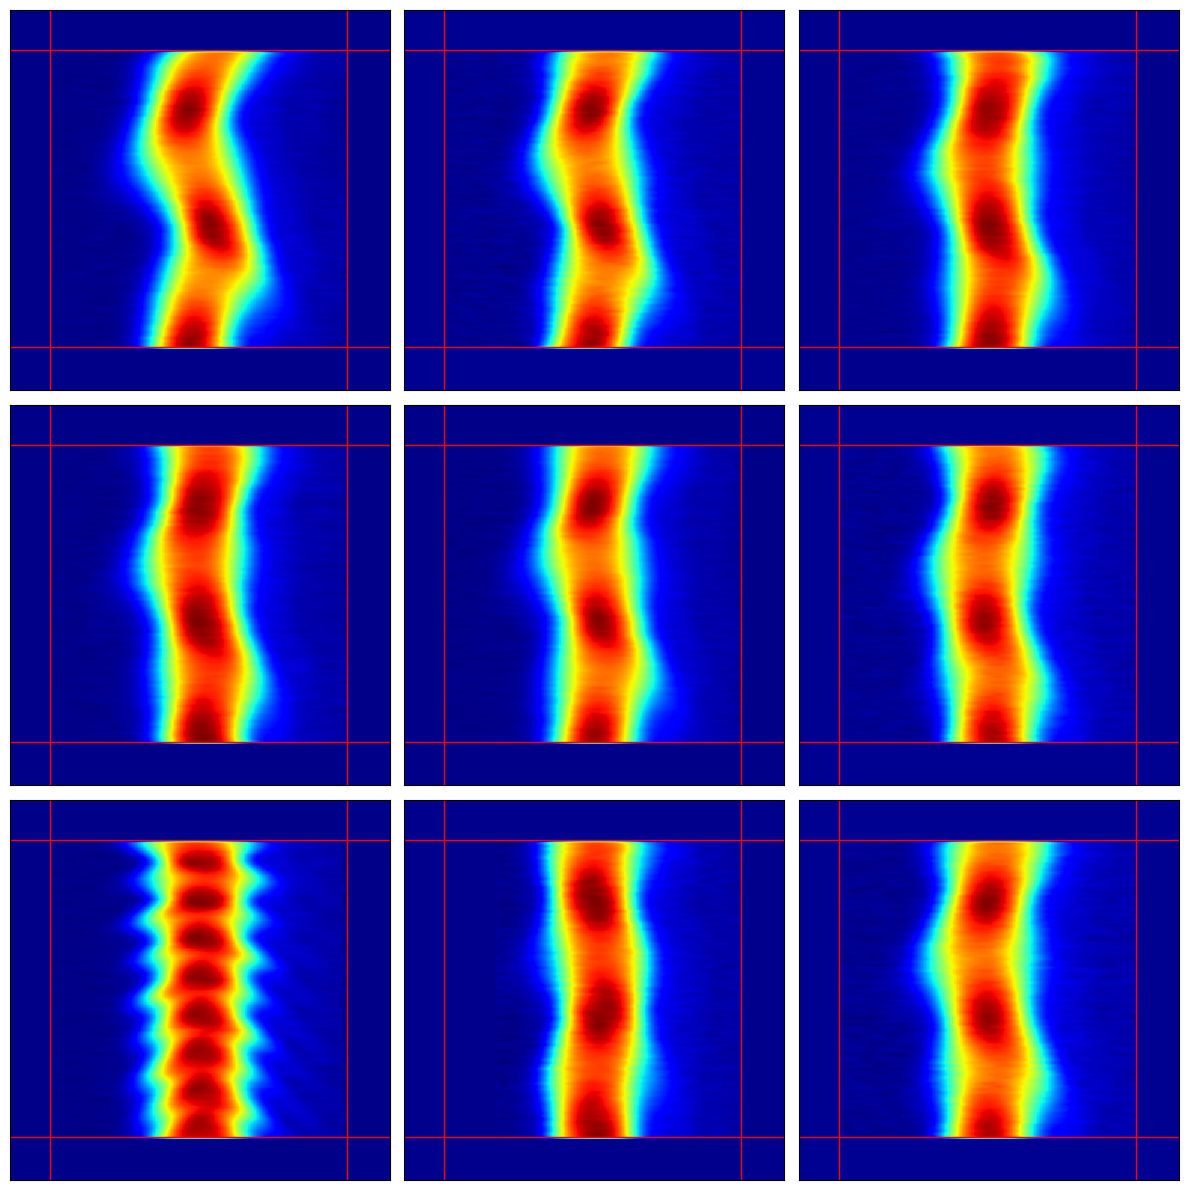

In [6]:
# plot some examples
import matplotlib.pyplot as plt
nrows = 3
samples = np.random.choice(np.arange(len(wf_test)),
                          size=nrows * nrows, replace=False)
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, 
                         figsize=(12, 12), sharex=True, sharey=True)
axes = np.ravel(axes)

for i in range(nrows * nrows):
    ax = axes[i]
    plt.sca(ax)
    sample = wf_test[samples[i], :, :, 0].T
    # hdensity = np.sum(sample, axis=0)
    # print('Max index:', np.argmax(hdensity))
    # offset = sample.shape[0]//2 - np.argmax(hdensity)
    # sample = np.roll(sample, offset, axis=1)
    

    ax.set_xticks([])
    ax.set_yticks([])
    plt.axhline(y=13, color='red', lw=1)
    plt.axvline(x=13, color='red', lw=1)
    plt.axhline(y=113, color='red', lw=1)
    plt.axvline(x=113, color='red', lw=1)
    ax.imshow(sample, cmap='jet')
    # plt.plot(hdensity, color='black')
plt.tight_layout()


In [7]:
# Load the model
print('Encoder: ', enc_timestamp)

# Initialize directories
enc_trial_dir = os.path.join('./trials/', enc_timestamp)
enc_weights_dir = os.path.join(enc_trial_dir, 'weights')
assert os.path.exists(enc_weights_dir)

print('Decoder: ', dec_timestamp)

# Initialize directories
dec_trial_dir = os.path.join('./trials/', dec_timestamp)
dec_weights_dir = os.path.join(dec_trial_dir, 'weights')
assert os.path.exists(dec_weights_dir)

# initialize directory to save the plots
timestamp = f'enc_{enc_timestamp}_dec_{dec_timestamp}'
print('Timestamp: ', timestamp)
plots_dir = os.path.join('./plots', 'acqInjection', timestamp)
os.makedirs(plots_dir, exist_ok=True)

encDec = EncoderDecoderModel()
encDec.load(enc_weights_dir=enc_weights_dir, dec_weights_dir=dec_weights_dir)


Encoder:  best_encoder_TF
Decoder:  best_decoder_TF
Timestamp:  enc_best_encoder_TF_dec_best_decoder_TF


2023-11-29 10:05:48.578476: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-11-29 10:05:48.590830: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-29 10:05:48.615393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2023-11-29 10:05:48.825365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

In [8]:
def assess_model_real_data(wf, wf_id, latent_pred, figname, savefig=False):
    '''
    Visual end-to-end evaluation. 
    Left: Waterfall (input)
    Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
    Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
    '''
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5), 
                             gridspec_kw={'width_ratios': [6, 2]})

    wf_s = np.array(wf).reshape(128, 128).T
    # wf_s = wf_s[zeropad:-zeropad, zeropad:-zeropad]
    latent_pred = latent_pred.numpy().reshape((1, -1))

    latent_pred_unnorm = unnormalize_params(
        latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
        latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5],
        latent_pred[:, 6], normalization=normalization)
    
    # print(latent_pred_unnorm.shape)
    # start with left plot, the waterfall
    plt.sca(axes[0])
    plt.imshow(wf_s, cmap='jet')
    plt.title(f'{wf_id}', fontsize=12)
    # plt.xticks([], []); plt.yticks([], [])

    # right plot
    plt.sca(axes[1])
    # plt.gca().set_facecolor('xkcd:light grey')
    plt.axis('off')
    rowLabels = ['PhaseEr', 'EnergyEr', 'B.Length', 'B.Inten', 'LHC_VRF', 'mu', 'SPS_VRF']
    rowColours = ['xkcd:light grey'] * len(rowLabels)
    colColours = ['xkcd:light grey']
    cellColours = [['white'] for i in range(len(rowLabels))]
    # rowLabels = [var_names[w] for w in loss_weights]
    cellText = [[f'{(latent[0]*mult):.2f} / {unit}'] for latent, unit, mult in zip(latent_pred_unnorm, units, multipliers)]
    # print(len(latent_pred_unnorm[0]))
    plt.table(cellText=cellText, rowLabels=rowLabels,
        colLabels=['Value'], loc='center', rowColours=rowColours, colColours=colColours,
          cellColours=cellColours)

    plt.tight_layout()
    if savefig:
        plt.savefig(figname, dpi=100, bbox_inches='tight')
    else:
        plt.show()
    plt.close()

In [9]:
out_dir = os.path.join(plots_dir, 'beam_parameters')
os.makedirs(out_dir, exist_ok=True)
latent_preds = encDec.encoder.predict(wf_test)
latent_preds_unnorm = unnormalize_params(
    latent_preds[:, 0], latent_preds[:, 1], latent_preds[:, 2],
    latent_preds[:, 3], latent_preds[:, 4], latent_preds[:, 5],
    latent_preds[:, 6], normalization=normalization)

In [157]:

for i in np.arange(len(wf_test))[:]:
    latent_pred = latent_preds[i]
    figname = os.path.join(out_dir, f'{wf_id[i]}_latent_space.png')
    assess_model_real_data(wf_test[i], wf_id[i], latent_pred, figname, savefig=True)


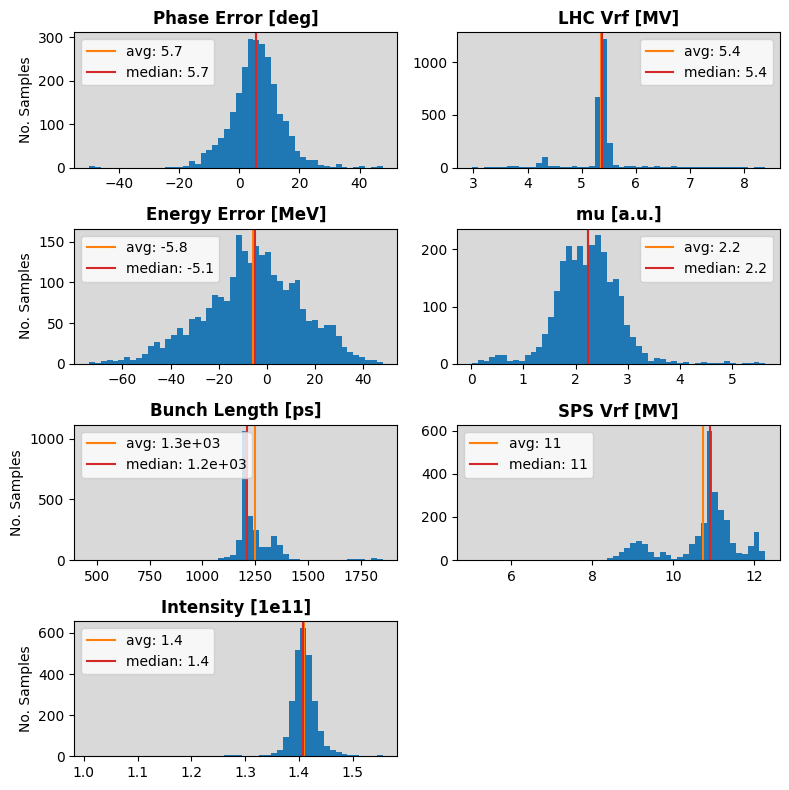

In [12]:
## Frequency distribution per beam parameter

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False, sharey=False,
                        figsize=(8, 8))
axes = np.ravel(axes, order='F')
for i, ax in enumerate(axes):
    if i == 7:
        break
    plt.sca(ax)
    values = latent_preds_unnorm[i] * multipliers[i]
    avg = np.mean(values)
    median = np.median(values)
    plt.axvline(x=avg, color='tab:orange', label=f'avg: {avg:.2g}')
    plt.axvline(x=median, color='tab:red', label=f'median: {median:.2g}')
    hist, bins, _ = plt.hist(values, bins=50)
    ax.set_title(f'{descriptive_names[i]}', fontweight='heavy')
    if i < 4:
        plt.ylabel('No. Samples')
    plt.legend(loc='best')
    plt.gca().set_facecolor('0.85')

fig.delaxes(axes[-1])
plt.tight_layout()
plt.savefig(f'{out_dir}/distribution_all.png', transparent=False, dpi=400)


In [26]:
# store the data
import re
regexp = re.compile('(b\d)_fill(\d+)_bckt(\d+)')
header = ['beam', 'fill', 'bucket', 'phase_er/deg',  'energy_er/MeV', 'bunch_length/ps', 'bunch_inten/1e9', 'lhc_vrf/MV', 'mu/au', 'sps_vrf/MV']

table = [header]

for i in range(len(latent_preds_unnorm[0])):
    match = regexp.match(wf_id[i])
    if not match:
        continue
    beam, fill, bucket = match.groups()
    row = [beam, fill, bucket] + [f'{l[i]*mult:.2f}' for l, mult in zip(latent_preds_unnorm, multipliers)]
    table.append(row)


In [31]:
import csv
f = open(os.path.join(out_dir, 'beam_params_table.csv'), 'w')
writer = csv.writer(f)
writer.writerows(table)

In [36]:
import csv

fill_numbers = ['9067', '9068', '9070', '9072', '9046',
                 '9049', '9050', '9056', '9057', '9061', '9062',
                   '9063', '9066']

selected_rows = []
for row in table:
    if row[1] in fill_numbers:
        selected_rows.append(row)

f = open(os.path.join(plots_dir,'beam_parameters_selected', 'beam_params_table.csv'), 'w')
writer = csv.writer(f)
writer.writerow(header)
writer.writerows(selected_rows)


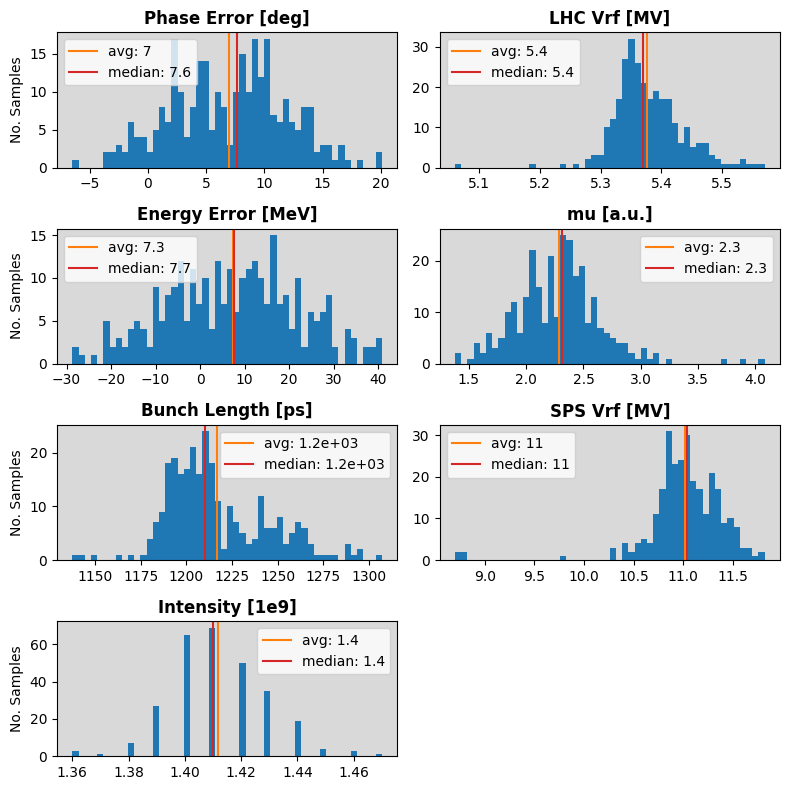

In [49]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False, sharey=False,
                        figsize=(8, 8))
axes = np.ravel(axes, order='F')
selected_data = np.array(selected_rows)
for i, ax in enumerate(axes):
    if i == 7:
        break
    plt.sca(ax)
    values = np.array(selected_data[:, 3+i], dtype=float)
    avg = np.mean(values)
    median = np.median(values)
    plt.axvline(x=avg, color='tab:orange', label=f'avg: {avg:.2g}')
    plt.axvline(x=median, color='tab:red', label=f'median: {median:.2g}')
    hist, bins, _ = plt.hist(values, bins=50)
    ax.set_title(f'{descriptive_names[i]}', fontweight='heavy')
    if i < 4:
        plt.ylabel('No. Samples')
    plt.legend(loc='best')
    plt.gca().set_facecolor('0.85')

fig.delaxes(axes[-1])
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'beam_parameters_selected', 'value_distribution.png'), transparent=False, dpi=400)